In [32]:
%%writefile /mnt/solexa/mel_yang/bronzeage/jda/jda_getpd_dfreq_downsample_noAFR.py
##Make frequency and read file, oriented by ancestry (allele in chimp)
##Treat sites fixed in Africans (Yoruba, Mandenka, Mbuti, Ju_hoan_North) as missing data - filter out!

import collections
import numpy as np
import sys
import random
#moderneas="Japanese"
moderneas=sys.argv[1]

pD1="/mnt/solexa/mel_yang/bronzeage/data/"
pD2="/mnt/solexa/mel_yang/bronzeage/jda_dfb/"
fh="ind_A_v13_TBH"
subset="fixedAfr_nobeta"
#subset="nobeta"
#indfilename="ind_A_v13_TBH_manualpdeasmerge"
indfilename="ind_A_v13_TBH_mergeHanALL"
indfile=open(pD1+indfilename+".ind",'r')
africans=["Yoruba", "Mandenka", "Mbuti", "Ju_hoan_North"]
pdeasall,africanall=[],[]
for ind,line in enumerate(indfile):
    x = line.split()
    if x[2] == moderneas: pdeasall.append(ind)
    if x[2] in africans: africanall.append(ind)
    if x[2] == "Chimp": ancind=ind ##ONLY 0/2, no heterozygotes
indfile.close()
print len(africanall)
print len(pdeasall)
for howmany in [10,25,40,50,75,100,111]: #[5,10,15,20,25,30]:
    pdeas=sorted(random.sample(pdeasall,howmany))

    newfile=open(pD2+indfilename+".pdEAS_"+subset+"."+moderneas+".ss"+str(howmany)+".dfreq",'w')
    #newfile.write(moderneas+".ss"+str(howmany)+'\n')
    #newfile.write('kref\tnref\n')
    #newfile.write('%s.ss%i\n' % (moderneas,howmany))
    newfile.write('AF\n')
    genofile=open(pD1+fh+".geno",'r')
    num=0
    for line in genofile:
        num+=1
        #if num==10: break
        ancgeno=int(line[ancind])
        easgeno=[int(line[ind]) for ind in pdeas]
        afrgeno=''.join([str(i) for i in list(set([int(line[ind]) for ind in africanall]))])
        #afrgeno='00'
        if afrgeno in ['09','90','29','92']: mydfreq=-5
        else: 
            if 9 in easgeno: mydfreq=-5
            else: 
                total=2.0*len(easgeno)
                secondallele=np.sum(easgeno)
                if ancgeno==0: mydfreq= secondallele/total
                elif ancgeno==2: mydfreq=1-(secondallele/total)
                else: print "ancgeno is", ancgeno
        dfreqs=mydfreq
        #if indiv=="Han_HGDP": print easgeno, ancgeno, mydfreq,mydfreq*66
        #newfile.write("%i\t%i" % (dfreqs,total) + '\n')
        newfile.write("%.4f" % dfreqs + '\n')

    newfile.close()


Overwriting /mnt/solexa/mel_yang/bronzeage/jda/jda_getpd_dfreq_downsample_noAFR.py


In [41]:
%%bash
pD="/mnt/solexa/mel_yang/bronzeage/jda/"
pD2="/mnt/solexa/mel_yang/bronzeage/jda_dfb/"
fh="ind_A_v13_TBH_mergeHanALL"
#subset="_nobeta"
subset="_fixedAfr_nobeta"
addon="_switchanc"
ref="HanALL"
for ss in 10 25 40 50 75 100 111; 
do
    paste ${pD}jda_anceas${addon}.chrompos ${pD2}${fh}.pdEAS${subset}.${ref}.ss${ss}.dfreq ${pD}jda_anceas${addon}.readcount > ${pD2}jda${subset}_anceas${addon}_${ref}.ss${ss}.comb
    #_nomissfixed.comb
done

In [42]:
##Remove missing or fixed data
##Remove 

pD2="/mnt/solexa/mel_yang/bronzeage/jda_dfb/"
addon="_switchanc"
#subset1="nobeta_"
subset1="fixedAfr_nobeta_"
subset2=subset1 #+"df5co_"
#subset2=subset1 #+"manualmerge_"
ref="HanALL"
ss=30
for ss in [10,25,40,50,75,100,111]:
#for ref in ["Japanese","French","Han_NChina","Han_SChina","Kazakh",
#            "TibetanSW","She_Miao_Tujia","Thai_Dai","Spanish","Yoruba"]:
    combfile=open(pD2+"jda_"+subset1+"anceas"+addon+"_"+ref+".ss"+str(ss)+".comb",'r')
    newcombfile=open(pD2+"jda_"+subset2+"anceas"+addon+"_"+ref+".ss"+str(ss)+"_nomissfixed.comb",'w')
    for line in combfile:
        x=line.split()
        if x[0] == "Chrom": newcombfile.write(line); continue
        if x[2] in ['0.0000',"-5.0000","1.0000"]: continue
        myfreq=float(x[2])
        if myfreq<0.05 or myfreq>0.95: continue
        #if myfreq<0.025 or myfreq>0.975: continue
        newcombfile.write(line)
    combfile.close()
    newcombfile.close()

In [45]:
%%writefile /home/mel_yang/projects/bronzeage/continuity/run_mel_job_all_HanALLss.py
from ancient_genotypes import *
from numpy import *
import pandas
import cPickle

pD="/mnt/solexa/mel_yang/bronzeage/jda_dfb/"
addon="_switchanc"
#refpop="HanALL"
refpop="Han_HGDP"
myss=[10,25,40,50,75,100,111]
myss=[10]
#subset1="nobeta"
#subset1="nobeta_df5co"
#subset1="fixedAfr_nobeta"
subset1=""
subset2=subset1


indfile=pD+"ancindivs.ind"
for ss in myss:
    myref=refpop
    #myref=refpop+".ss"+str(ss)
    readfile=pD+"jda"+subset1+"_anceas"+addon+"_"+myref+"_nomissfixed.comb"
    
    unique_pops, inds, label, pops, freqs, read_lists = parse_reads_by_pop(readfile,indfile,cutoff=0)

    params_pops = optimize_pop_params_error_parallel(freqs,read_lists,num_core=10,detail=0,continuity=False)
    cPickle.dump(params_pops,open(pD+subset2+"ind_A_v13_TBH"+addon+"."+myref+"_contFalse.pickle","w"))
    params_pops = optimize_pop_params_error_parallel(freqs,read_lists,num_core=10,detail=0,continuity=True)
    cPickle.dump(params_pops,open(pD+subset2+"ind_A_v13_TBH"+addon+"."+myref+"_contTrue.pickle","w"))


Overwriting /home/mel_yang/projects/bronzeage/continuity/run_mel_job_all_HanALLss.py


_______________________
HanALL.ss111
False Balikun 22976.5994796 [0.021642133169830841, 9.9999879656705755, 0.06176097070896875]
True Balikun 23056.8543678 [0.036643978496937943, 0.039956429837976905]
_______________________
HanALL.ss111
False Donghuigou 431336.852629 [0.032492770504045719, 0.088348670547781574, 0.028803378301641969, 0.022809655463085946, 0.04097553695252442, 0.055129268232076284, 0.035049658519964992, 0.025465770905245034]
True Donghuigou 432255.862982 [0.055422965238470429, 0.022778840417843987, 0.018985937433454246, 0.03608243125657877, 0.050267787357985719, 0.036074292862301918, 0.02118279597072267]
_______________________
HanALL.ss111
False Guandimiao 267925.367725 [1e-10, 0.030212726063273569, 0.012508813761115171, 0.012505105887537409, 0.01757905611236173]
True Guandimiao 268020.783626 [0.0032630446348638079, 0.011489922453623739, 0.011636656838370773, 0.016366755190189528]
_______________________
HanALL.ss111
False Guandimiao_contaminated 26252.1925512 [1e-10, 

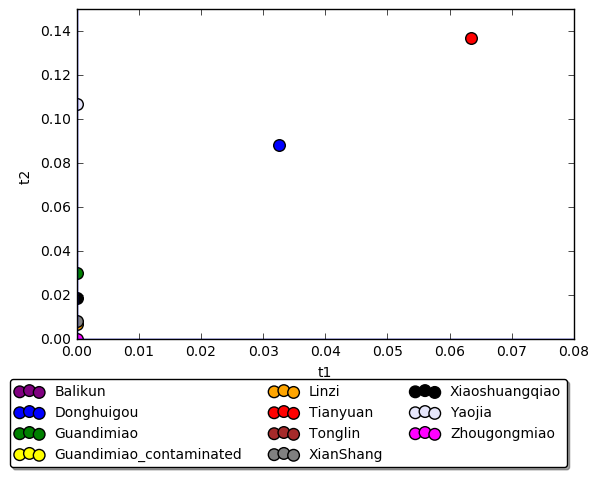

In [65]:
%matplotlib inline

import cPickle
import matplotlib.pyplot as plt
pD="/mnt/solexa/mel_yang/bronzeage/jda_dfb/"
addon="_switchanc"
subset="nobeta_"
subset="dfb1_beta1_"
refpops=["Han_HGDP"]
refpops=["HanALL.ss111"]
mypops=[]
indfile=open(pD+"ancindivs.ind",'r')
for line in indfile: 
    x=line.split()
    if x[2] in mypops: continue
    else: mypops.append(x[2])
        
mypops=sorted(mypops)

popiwant="Zhougongmiao"
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for myind,popiwant in enumerate(mypops):
    
    t1f,t2f,t1t,t2t=[],[],[],[]
    for refpop in refpops:
        print "_______________________"
        print refpop
        falsefile=open(pD+subset+"ind_A_v13_TBH"+addon+"."+refpop+"_contFalse.pickle",'r')
        falsedat=cPickle.load(falsefile)
        truefile=open(pD+subset+"ind_A_v13_TBH"+addon+"."+refpop+"_contTrue.pickle",'r')
        truedat=cPickle.load(truefile)
        #print falsedat

        for ind,mypop in enumerate(falsedat):
            #if ind in [0,2,3,4]: continue
            #if ind in [0,1,2,3]: continue
            if mypops[ind] == popiwant:
                print "False", mypops[ind],mypop[1], list(mypop[0])
                print "True", mypops[ind],truedat[ind][1],list(truedat[ind][0])
                t1f.append(mypop[0][0])
                t2f.append(mypop[0][1])
                t1t.append(truedat[ind][0][0])
                t2t.append(truedat[ind][0][1])


    colors=["purple","blue","green","yellow","orange","red","brown",
            "gray","black","lavender","fuchsia","goldenrod","peachpuff","cyan",
            "lawngreen","mediumslateblue"]
    #print t1f
    #for i in range(len(t1f)):
        #handles.append(ax.scatter(t1f[i],t2f[i],c=colors[i],label=refpops[i]))
    i=0
    ax.scatter(t1f[i],t2f[i],label=mypops[myind],c=colors[myind],s=70)
    
    ax.set_xlim((0,0.08))
    ax.set_ylim((0,0.15))
    ax.set_xlabel("t1")
    ax.set_ylabel("t2 ") #+popiwant)
ax.legend(fontsize=10,bbox_to_anchor=(1, -0.1),ncol=3, fancybox=True, shadow=True)
ax.axhline(y=0)
ax.axvline(x=0)
fig.tight_layout()